In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

import shap

import joblib

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
fs = pd.read_csv(r'C:\Users\Gabriel\OneDrive\CUSP\Spring 2022 Classes\Capstone\PANYNJ-codebase\fs_pax.csv')
fs.head()

,Unnamed: 0,DT_sched,Flight No,iata_code,International Domestic,Flight Distance,Flight Duration,Operating Airline Name,airline_icao,airline_type,Departure Concourse,date,Time,year,DOW_l,holiday,total_doses,BTS Aircraft Type Desc_1,ICAO Aircraft Code,IATA Aircraft Code,Seats,LF_adj,PAX_adj,PAX_bus,PAX_lei,airline_type_dum,region,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Hour_0,Hour_1,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,0,2021-01-02 11:15:00,106,DEL,International,7323,820,Air India,AIC,TR,B3,2021-01-02,11:15,2021,Saturday,1,4745800,BOEING 777-200/200LR,B772,77L,238,0.531511,168.330972,57.863772,110.467201,0,Asia,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2021-01-01 19:30:00,101,ORY,International,3648,440,La Compagnie,DJT,TR,B2,2021-01-01,19:30,2021,Friday,1,4438527,AIRBUS INDUSTRIE A321,A321,321,76,0.000000,0.000000,0.000000,0.000000,0,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2,2021-01-02 19:30:00,101,ORY,International,3648,440,La Compagnie,DJT,TR,B2,2021-01-02,19:30,2021,Saturday,1,4745800,AIRBUS INDUSTRIE A321,A321,321,76,0.000000,0.000000,0.000000,0.000000,0,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,2021-01-01 21:50:00,103,ORY,International,3648,430,La Compagnie,DJT,TR,B3,2021-01-01,21:50,2021,Friday,1,4438527,AIRBUS INDUSTRIE A321,A321,321,76,0.447152,51.042195,17.545754,33.496440,0,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,4,2021-01-02 21:50:00,103,ORY,International,3648,430,La Compagnie,DJT,TR,B3,2021-01-02,21:50,2021,Saturday,1,4745800,AIRBUS INDUSTRIE A321,A321,321,76,0.489067,55.826857,19.190482,36.636375,0,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [3]:
fs['DT_sched'] = pd.to_datetime(fs['DT_sched'])

In [4]:
fs = fs.sort_values('DT_sched')
fs.head()

,Unnamed: 0,DT_sched,Flight No,iata_code,International Domestic,Flight Distance,Flight Duration,Operating Airline Name,airline_icao,airline_type,Departure Concourse,date,Time,year,DOW_l,holiday,total_doses,BTS Aircraft Type Desc_1,ICAO Aircraft Code,IATA Aircraft Code,Seats,LF_adj,PAX_adj,PAX_bus,PAX_lei,airline_type_dum,region,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Hour_0,Hour_1,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
56,56,2021-01-01 00:59:00,1035,SJU,Domestic,1608,256,Spirit Airlines,NKS,LC,B3,2021-01-01,00:59,2021,Friday,1,4438527,AIRBUS INDUSTRIE A321,A321,32B,228,1.172795,213.448633,32.610208,180.838425,1,Latin America & Caribbean,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
89,89,2021-01-01 06:00:00,521,FLL,Domestic,1065,188,Spirit Airlines,NKS,LC,B1,2021-01-01,06:00,2021,Friday,1,4438527,AIRBUS INDUSTRIE A321,A321,32B,228,0.818869,149.302328,22.810078,126.492250,1,USA-Southeast,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,23,2021-01-01 06:00:00,1646,DTW,Domestic,488,117,Delta Air Lines,DAL,TR,B1,2021-01-01,06:00,2021,Friday,1,4438527,AIRBUS INDUSTRIE A220-100,BCS1,221,109,0.764830,57.806095,8.831487,48.974608,0,USA-Midwest,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32,32,2021-01-01 06:15:00,2060,ATL,Domestic,746,137,Delta Air Lines,DAL,TR,B1,2021-01-01,06:15,2021,Friday,1,4438527,BOEING 737-900,B738,738,160,0.716907,101.766704,15.547691,86.219013,0,USA-Southeast,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31,31,2021-01-01 06:15:00,2060,ATL,Domestic,746,137,Delta Air Lines,DAL,TR,B1,2021-01-01,06:15,2021,Friday,1,4438527,BOEING 737-800,B738,738,160,0.716907,101.766704,15.547691,86.219013,0,USA-Southeast,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
fs['Flight No'] = fs['Flight No'].astype('float')

In [6]:
# add a new feature to the flight schedule for the number of flights in the hour preceding the scheduled flight

In [7]:
#this is the more proper way to create this variable, but it takes a long time to run.
# Since this will be part of the pipeline, I want it to run faster
# fs['flight_count'] = 0
# for i in fs.index:
#     onehr = fs.loc[i,'DT_sched'] - dt.timedelta(hours=1)
#     fs.loc[i,'flight_count'] = len(fs[(fs['DT_sched'] >= onehr) & (fs['DT_sched'] <= fs.loc[i,'DT_sched'])])

In [8]:
# this approach is faster because it only groups the flights hourly one time instead of in a for loop.
# the downside is that a flight at 5:01am will have the flights 5-6am associated with it instead of 4:01-5:01.
# actually, let's group by 30 minute interval then use the interval of the scheduled flight + the previous 30 minute interval
f_count = fs[['DT_sched','Flight No']].groupby(pd.Grouper(key = 'DT_sched', freq='30t')).count()
f_count

,Flight No
DT_sched,
2021-01-01 00:30:00,1
2021-01-01 01:00:00,0
2021-01-01 01:30:00,0
2021-01-01 02:00:00,0
2021-01-01 02:30:00,0
...,...
2021-12-31 21:30:00,2
2021-12-31 22:00:00,0
2021-12-31 22:30:00,0


In [9]:
f_count['fcount_rolling'] = f_count['Flight No'].rolling(min_periods=1, window=2).sum()
f_count.tail(10)

,Flight No,fcount_rolling
DT_sched,,
2021-12-31 19:00:00,1,2.0
2021-12-31 19:30:00,1,2.0
2021-12-31 20:00:00,0,1.0
2021-12-31 20:30:00,4,4.0
2021-12-31 21:00:00,1,5.0
2021-12-31 21:30:00,2,3.0
2021-12-31 22:00:00,0,2.0
2021-12-31 22:30:00,0,0.0
2021-12-31 23:00:00,2,2.0


In [10]:
fs['hr_sched'] = fs['DT_sched'].dt.floor(freq='1H')
fs['t30_sched'] = fs['DT_sched'].dt.floor(freq='30t')
fs.tail()

,Unnamed: 0,DT_sched,Flight No,iata_code,International Domestic,Flight Distance,Flight Duration,Operating Airline Name,airline_icao,airline_type,Departure Concourse,date,Time,year,DOW_l,holiday,total_doses,BTS Aircraft Type Desc_1,ICAO Aircraft Code,IATA Aircraft Code,Seats,LF_adj,PAX_adj,PAX_bus,PAX_lei,airline_type_dum,region,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Hour_0,Hour_1,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,hr_sched,t30_sched
19764,19764,2021-12-31 21:50:00,188.0,LHR,International,3465,400,British Airways,BAW,TR,B2,2021-12-31,21:50,2021,Friday,1,530651301,BOEING 787-800 DREAMLINER,B788,788,214,0.534254,127.748898,17.263365,110.485533,0,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,12,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2021-12-31 21:00:00,2021-12-31 21:30:00
19760,19760,2021-12-31 23:10:00,1293.0,STI,International,1476,206,JetBlue Airways,JBU,LC,B2,2021-12-31,23:10,2021,Friday,1,530651301,AIRBUS INDUSTRIE A320-100/200,A320,320,162,0.645059,104.499546,14.121560,90.377986,1,Latin America & Caribbean,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2021-12-31 23:00:00,2021-12-31 23:00:00
19796,19796,2021-12-31 23:25:00,721.0,ORY,International,3648,430,French Bee,FBU,LC,B2,2021-12-31,23:25,2021,Friday,1,530651301,AIRBUS INDUSTRIE A350-900,A359,359,411,0.595318,244.675610,33.064272,211.611339,1,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2021-12-31 23:00:00,2021-12-31 23:00:00
19771,19771,2021-12-31 23:55:00,210.0,ATH,International,4948,555,Emirates,UAE,TR,B2,2021-12-31,23:55,2021,Friday,1,530651301,BOEING 777-300/300ER/333ER,B77W,77W,354,0.514087,179.930434,24.314923,155.615510,0,Europe,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2021-12-31 23:00:00,2021-12-31 23:30:00
19793,19793,2021-12-31 23:59:00,403.0,SDQ,International,1557,216,JetBlue Airways,JBU,LC,B3,2021-12-31,23:59,2021,Friday,1,530651301,AIRBUS INDUSTRIE A320-100/200,A320,320,162,0.612963,99.300037,13.418924,85.881113,1,Latin America & Caribbean,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2021-12-31 23:00:00,2021-12-31 23:30:00


In [11]:
fs = pd.merge(fs, f_count['fcount_rolling'],how='left',left_on='t30_sched',right_index=True)

### Aerobahn data without block schedule (probably ignore this)

In [12]:
ab = pd.read_csv(r'C:\Users\Gabriel\OneDrive\CUSP\Spring 2022 Classes\Capstone\Data\Aerobahn Detailed CUSP Export.csv')
ab.head()

,Date,Military Hour,Minutes,Military Time,Flight Direction,PA Airport Code,Terminal Desc,Concourse Desc,Gate Desc,Non-PA Airport Code,Non-PA Airport Country Desc,State Desc,Marketing Airline Desc,Marketing Airline ICAO Code,Operating Airline Desc,Operating Airline ICAO Code,Call Sign,General Aircraft Desc,Variant Aircraft Desc,Variant Aircraft Code,Max Seats,Total Flights
0,1/1/2021,0.0,22.0,00:22:45,Arrival,EWR,EWR-Terminal B,Concourse B-1,B41B,SJU,USA,Puerto Rico,Spirit Airlines,NKS,Spirit Airlines,NKS,NKS1036,Airbus A318/319/320/321,Airbus A321,A321,185.0,1
1,1/1/2021,1.0,5.0,01:05:58,Departure,EWR,EWR-Terminal B,Concourse B-3,B61,SJU,USA,Puerto Rico,Spirit Airlines,NKS,Spirit Airlines,NKS,NKS1035,Airbus A318/319/320/321,Airbus A321,A321,185.0,1
2,1/1/2021,1.0,47.0,01:47:14,Arrival,EWR,EWR-Terminal B,Concourse B-2,B56,STI,Dominican Republic,International,JetBlue Airways,JBU,JetBlue Airways,JBU,JBU1494,Airbus A318/319/320/321,Airbus A321,A321,185.0,1
3,1/1/2021,4.0,9.0,04:09:16,Arrival,EWR,EWR-Terminal B,Concourse B-2,B53,TLV,Israel,International,United Airlines,UAL,United Airlines,UAL,UAL91,Boeing 787,Boeing 787-9,B789,280.0,1
4,1/1/2021,4.0,13.0,04:13:44,Arrival,EWR,EWR-Terminal B,Concourse B-2,B55,DEL,India,International,United Airlines,UAL,United Airlines,UAL,UAL802,Boeing 777 Freighter,Boeing 777-200F Freighter,77X,0.0,1


In [13]:
ab = ab[ab['Flight Direction'] == 'Departure']
ab.shape

(18913, 22)

In [14]:
ab['datetime'] = pd.to_datetime(ab['Date'] + ' ' + ab['Military Time'])
ab = ab.sort_values('datetime')

In [15]:
# The call sign is the combination of the 3-character Operating Airline ICAO Code and the Flight Number
# There are a few exceptions, mainly La Compagnie (DJT), whose Call Sign is B0101.
ab[ab['Call Sign'].str[:3] != ab['Operating Airline ICAO Code']].head(10)

,Date,Military Hour,Minutes,Military Time,Flight Direction,PA Airport Code,Terminal Desc,Concourse Desc,Gate Desc,Non-PA Airport Code,Non-PA Airport Country Desc,State Desc,Marketing Airline Desc,Marketing Airline ICAO Code,Operating Airline Desc,Operating Airline ICAO Code,Call Sign,General Aircraft Desc,Variant Aircraft Desc,Variant Aircraft Code,Max Seats,Total Flights,datetime
7477,3/15/2021,20.0,34.0,20:34:42,Departure,EWR,EWR-Terminal B,Concourse B-2,B54,Unknown,Unknown,International,General Aviation,GA,Unknown,Unknown,RLJ505,De Havilland,H25B,H25B,0.0,1,2021-03-15 20:34:42
19477,6/16/2021,8.0,7.0,08:07:04,Departure,EWR,EWR-Terminal B,Concourse B-1,B43,SBY,USA,Maryland,General Aviation,GA,Unknown,Unknown,N848FE,Cessna,Cessna 208 Caravan,C208,0.0,1,2021-06-16 08:07:04
23565,7/10/2021,19.0,16.0,19:16:51,Departure,EWR,EWR-Terminal B,Concourse B-2,B52,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190.0,1,2021-07-10 19:16:51
24462,7/15/2021,19.0,19.0,19:19:54,Departure,EWR,EWR-Terminal B,Concourse B-2,B51,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190.0,1,2021-07-15 19:19:54
24675,7/16/2021,21.0,52.0,21:52:22,Departure,EWR,EWR-Terminal B,Concourse B-2,B51,NCE,France,International,General Aviation,GA,La Compagnie,DJT,B0201,Airbus A318/319/320/321,Airbus A321neo,32Q,190.0,1,2021-07-16 21:52:22
24796,7/17/2021,21.0,17.0,21:17:02,Departure,EWR,EWR-Terminal B,Concourse B-2,B57,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190.0,1,2021-07-17 21:17:02
26058,7/24/2021,19.0,4.0,19:04:03,Departure,EWR,EWR-Terminal B,Concourse B-2,B51,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190.0,1,2021-07-24 19:04:03
26626,7/27/2021,19.0,13.0,19:13:54,Departure,EWR,EWR-Terminal B,Concourse B-2,B51,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190.0,1,2021-07-27 19:13:54
26798,7/28/2021,19.0,15.0,19:15:28,Departure,EWR,EWR-Terminal B,Concourse B-2,B51,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190.0,1,2021-07-28 19:15:28
27348,7/31/2021,19.0,18.0,19:18:37,Departure,EWR,EWR-Terminal B,Concourse B-2,B57,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190.0,1,2021-07-31 19:18:37


In [16]:
# Replace B0 call sign prefix with DJT so that the merge will work better
ab['Call Sign'] = ab['Call Sign'].str.replace('B0','DJT')

In [17]:
# Actually the processed flight schedule data just has the Marketing Airline ICAO code, not the Operating one. So we will merge on the Marketing Airline ICAO Code (also in AB)
# and the flight number, which are the numbers in the call sign after the first 3 characters

ab['flight_number'] = ab['Call Sign'].str[3:]

In [18]:
# Some (336) flights in the AB dataset have a Marketing Airline of "General Aviation" (GA). Let's replace these instances with Operating Airline ICAO Code
ab[ab['Marketing Airline ICAO Code'] == 'GA'].head()

,Date,Military Hour,Minutes,Military Time,Flight Direction,PA Airport Code,Terminal Desc,Concourse Desc,Gate Desc,Non-PA Airport Code,Non-PA Airport Country Desc,State Desc,Marketing Airline Desc,Marketing Airline ICAO Code,Operating Airline Desc,Operating Airline ICAO Code,Call Sign,General Aircraft Desc,Variant Aircraft Desc,Variant Aircraft Code,Max Seats,Total Flights,datetime,flight_number
7477,3/15/2021,20.0,34.0,20:34:42,Departure,EWR,EWR-Terminal B,Concourse B-2,B54,Unknown,Unknown,International,General Aviation,GA,Unknown,Unknown,RLJ505,De Havilland,H25B,H25B,0.0,1,2021-03-15 20:34:42,505
7878,3/19/2021,8.0,58.0,08:58:10,Departure,EWR,EWR-Terminal B,Concourse B-1,B43,ANU,"Antigua and Barbuda, Leeward Islands",International,General Aviation,GA,Hex'Air,HER,HER978,Cessna (Light Aircraft),C750,C750,0.0,1,2021-03-19 08:58:10,978
15115,5/16/2021,7.0,51.0,07:51:30,Departure,EWR,EWR-Terminal B,Concourse B-3,B65,RIX,Latvia,International,General Aviation,GA,Arkefly,TFL,TFL7810,Boeing 787,Boeing 787-8,788,242.0,1,2021-05-16 07:51:30,7810
17471,6/3/2021,0.0,58.0,00:58:54,Departure,EWR,EWR-Terminal B,Concourse B-3,B62,IST,Turkey,International,General Aviation,GA,Turkish Airlines,THY,THY30,Airbus A330,Airbus A330-300,333,335.0,1,2021-06-03 00:58:54,30
17762,6/5/2021,0.0,56.0,00:56:31,Departure,EWR,EWR-Terminal B,Concourse B-3,B65,IST,Turkey,International,General Aviation,GA,Turkish Airlines,THY,THY30,Airbus A330,Airbus A330-300,333,335.0,1,2021-06-05 00:56:31,30


In [19]:
#replace GA with Operating Airline ICAO Code
ab.loc[ab['Marketing Airline ICAO Code'] == 'GA','Marketing Airline ICAO Code'] = ab.loc[ab['Marketing Airline ICAO Code'] == 'GA','Operating Airline ICAO Code']

In [20]:
# need to recast flight number in AB to numeric, but there are a few flight numbers with suffixes. Apparently this likely means they were unscheduled flights
ab[~ab['flight_number'].str.isnumeric()]

,Date,Military Hour,Minutes,Military Time,Flight Direction,PA Airport Code,Terminal Desc,Concourse Desc,Gate Desc,Non-PA Airport Code,Non-PA Airport Country Desc,State Desc,Marketing Airline Desc,Marketing Airline ICAO Code,Operating Airline Desc,Operating Airline ICAO Code,Call Sign,General Aircraft Desc,Variant Aircraft Desc,Variant Aircraft Code,Max Seats,Total Flights,datetime,flight_number
18261,6/8/2021,8.0,51.0,08:51:31,Departure,EWR,EWR-Terminal B,Concourse B-3,B65,AMS,Netherlands,International,General Aviation,TFL,Arkefly,TFL,TFL76P,Boeing 787,Boeing 787-8,788,242.0,1,2021-06-08 08:51:31,76P
19477,6/16/2021,8.0,7.0,08:07:04,Departure,EWR,EWR-Terminal B,Concourse B-1,B43,SBY,USA,Maryland,General Aviation,Unknown,Unknown,Unknown,N848FE,Cessna,Cessna 208 Caravan,C208,0.0,1,2021-06-16 08:07:04,8FE
29992,8/15/2021,22.0,7.0,22:07:34,Departure,EWR,EWR-Terminal B,Concourse B-3,B65,LIS,Portugal,International,TAP Portugal,TAP,TAP Portugal,TAP,TAP202B,Airbus A330,Airbus A330-900,A339,350.0,1,2021-08-15 22:07:34,202B
33178,9/2/2021,18.0,38.0,18:38:56,Departure,EWR,EWR-Terminal B,Concourse B-1,B40,MCO,USA,Florida,Frontier Airlines,FFT,Frontier Airlines,FFT,FFT259A,Airbus A318/319/320/321,Airbus A320,A320,150.0,1,2021-09-02 18:38:56,259A
49027,12/8/2021,23.0,14.0,23:14:55,Departure,EWR,EWR-Terminal B,Concourse B-3,B68,LIS,Portugal,International,TAP Portugal,TAP,TAP Portugal,TAP,TAP202H,Airbus A330,Airbus A330-900,A339,350.0,1,2021-12-08 23:14:55,202H


In [21]:
# we can coerce the conversion to numeric and ignore those unscheduled flights
ab['flight_number'] = pd.to_numeric(ab['flight_number'],errors='coerce')

In [22]:
# merge_asof allows us to specify hard matching with the "by" arguments and soft matching with the "on" argument.
# Baseically, I looked for the nearest actual departure time that matched with a corresponding scheduled flight
mg = pd.merge_asof(fs, ab[['Marketing Airline ICAO Code','flight_number','Non-PA Airport Code','datetime','Concourse Desc','Gate Desc','Call Sign']],
    left_by = ['airline_icao','Flight No','iata_code'], 
    right_by = ['Marketing Airline ICAO Code','flight_number','Non-PA Airport Code'],
    left_on = 'DT_sched',right_on = 'datetime',direction = 'nearest')

In [23]:
mg['delay'] = mg['datetime'] - mg['DT_sched']

In [24]:
mg['delay'].describe()

count                         19479
mean      0 days 21:28:38.612454438
std      12 days 22:20:44.292524137
min              -15 days +23:53:45
25%                 0 days 00:08:01
50%                 0 days 00:14:40
75%                 0 days 00:31:02
max               301 days 23:36:49
Name: delay, dtype: object

In [25]:
mg['delay_hours'] = mg['delay'].dt.total_seconds() / 3600
mg['delay_minutes'] = mg['delay'].dt.total_seconds() / 60

<AxesSubplot:>

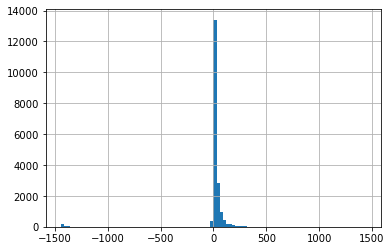

In [26]:
mg['delay_minutes'].hist(range = (-60*24,60*24),bins=100)

In [27]:
mg.loc[np.abs(mg['delay_hours']) > 12,
['delay','DT_sched','datetime','Flight No','flight_number','iata_code','Non-PA Airport Code','Operating Airline Name','airline_icao','Marketing Airline ICAO Code']].sort_values('delay')

,delay,DT_sched,datetime,Flight No,flight_number,iata_code,Non-PA Airport Code,Operating Airline Name,airline_icao,Marketing Airline ICAO Code
1590,-15 days +23:53:45,2021-02-13 15:10:00,2021-01-30 15:03:45,399.0,399.0,SAL,SAL,Avianca,AVA,AVA
2161,-15 days +23:54:45,2021-03-01 11:55:00,2021-02-15 11:49:45,1312.0,1312.0,CVG,CVG,Allegiant Air,AAY,AAY
19759,-13 days +02:20:11,2021-12-31 06:50:00,2021-12-18 09:10:11,993.0,993.0,LAS,LAS,Spirit Airlines,NKS,NKS
19672,-12 days +02:20:11,2021-12-30 06:50:00,2021-12-18 09:10:11,993.0,993.0,LAS,LAS,Spirit Airlines,NKS,NKS
1482,-12 days +23:53:45,2021-02-10 15:10:00,2021-01-30 15:03:45,399.0,399.0,SAL,SAL,Avianca,AVA,AVA
...,...,...,...,...,...,...,...,...,...,...
396,293 days 23:36:49,2021-01-09 23:55:00,2021-10-30 23:31:49,721.0,721.0,ORY,ORY,French Bee,FBU,FBU
362,294 days 23:36:49,2021-01-08 23:55:00,2021-10-30 23:31:49,721.0,721.0,ORY,ORY,French Bee,FBU,FBU
323,295 days 23:36:49,2021-01-07 23:55:00,2021-10-30 23:31:49,721.0,721.0,ORY,ORY,French Bee,FBU,FBU
105,300 days 23:36:49,2021-01-02 23:55:00,2021-10-30 23:31:49,721.0,721.0,ORY,ORY,French Bee,FBU,FBU


### Using the Aerobahn data that includes the block schedule

In [28]:
ab_sch = pd.read_csv(r'C:\Users\Gabriel\OneDrive\CUSP\Spring 2022 Classes\Capstone\PANYNJ-codebase\FlightDelay\Data\Aerobahn_with_Schedule.csv')
ab_sch.head()

,Date,Military Hour,Minutes,Military Time,Block Schedule,Flight Direction,PA Airport Code,Terminal Desc,Concourse Desc,Gate Desc,Non-PA Airport Code,Non-PA Airport Country Desc,State Desc,Marketing Airline Desc,Marketing Airline ICAO Code,Operating Airline Desc,Operating Airline ICAO Code,Call Sign,General Aircraft Desc,Variant Aircraft Desc,Variant Aircraft Code,Max Seats,Total Flights
0,1/1/2021,0,22,0:22:45,1/1/2021 0:59,Arrival,EWR,EWR-Terminal B,Concourse B-1,B41B,SJU,USA,Puerto Rico,Spirit Airlines,NKS,Spirit Airlines,NKS,NKS1036,Airbus A318/319/320/321,Airbus A321,A321,185,1
1,1/1/2021,1,5,1:05:58,1/1/2021 0:59,Departure,EWR,EWR-Terminal B,Concourse B-3,B61,SJU,USA,Puerto Rico,Spirit Airlines,NKS,Spirit Airlines,NKS,NKS1035,Airbus A318/319/320/321,Airbus A321,A321,185,1
2,1/1/2021,1,47,1:47:14,1/1/2021 1:29,Arrival,EWR,EWR-Terminal B,Concourse B-2,B56,STI,Dominican Republic,International,JetBlue Airways,JBU,JetBlue Airways,JBU,JBU1494,Airbus A318/319/320/321,Airbus A321,A321,185,1
3,1/1/2021,4,9,4:09:16,1/1/2021 4:45,Arrival,EWR,EWR-Terminal B,Concourse B-2,B53,TLV,Israel,International,United Airlines,UAL,United Airlines,UAL,UAL91,Boeing 787,Boeing 787-9,B789,280,1
4,1/1/2021,4,13,4:13:44,1/1/2021 4:25,Arrival,EWR,EWR-Terminal B,Concourse B-2,B55,DEL,India,International,United Airlines,UAL,United Airlines,UAL,UAL802,Boeing 777 Freighter,Boeing 777-200F Freighter,77X,0,1


In [29]:
#filter for departures only
ab_sch = ab_sch[ab_sch['Flight Direction'] == 'Departure']
#convert to datetime
ab_sch['dep_dt'] = pd.to_datetime(ab_sch['Date'] + ' ' + ab_sch['Military Time'])
ab_sch['sch_dt'] = pd.to_datetime(ab_sch['Block Schedule'])
#sort (for no good reason)
ab_sch = ab_sch.sort_values('sch_dt')

In [30]:
# The call sign is the combination of the 3-character Operating Airline ICAO Code and the Flight Number
# There are a few exceptions, mainly La Compagnie (DJT), whose Call Sign is B0101.
ab_sch[ab_sch['Call Sign'].str[:3] != ab_sch['Operating Airline ICAO Code']].head(10)

,Date,Military Hour,Minutes,Military Time,Block Schedule,Flight Direction,PA Airport Code,Terminal Desc,Concourse Desc,Gate Desc,Non-PA Airport Code,Non-PA Airport Country Desc,State Desc,Marketing Airline Desc,Marketing Airline ICAO Code,Operating Airline Desc,Operating Airline ICAO Code,Call Sign,General Aircraft Desc,Variant Aircraft Desc,Variant Aircraft Code,Max Seats,Total Flights,dep_dt,sch_dt
19477,6/16/2021,8,7,8:07:04,6/16/2021 7:30,Departure,EWR,EWR-Terminal B,Concourse B-1,B43,SBY,USA,Maryland,General Aviation,GA,Unknown,Unknown,N848FE,Cessna,Cessna 208 Caravan,C208,0,1,2021-06-16 08:07:04,2021-06-16 07:30:00
23565,7/10/2021,19,16,19:16:51,7/10/2021 19:00,Departure,EWR,EWR-Terminal B,Concourse B-2,B52,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190,1,2021-07-10 19:16:51,2021-07-10 19:00:00
24462,7/15/2021,19,19,19:19:54,7/15/2021 19:00,Departure,EWR,EWR-Terminal B,Concourse B-2,B51,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190,1,2021-07-15 19:19:54,2021-07-15 19:00:00
24675,7/16/2021,21,52,21:52:22,7/16/2021 21:40,Departure,EWR,EWR-Terminal B,Concourse B-2,B51,NCE,France,International,General Aviation,GA,La Compagnie,DJT,B0201,Airbus A318/319/320/321,Airbus A321neo,32Q,190,1,2021-07-16 21:52:22,2021-07-16 21:40:00
24796,7/17/2021,21,17,21:17:02,7/17/2021 19:00,Departure,EWR,EWR-Terminal B,Concourse B-2,B57,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190,1,2021-07-17 21:17:02,2021-07-17 19:00:00
26058,7/24/2021,19,4,19:04:03,7/24/2021 19:00,Departure,EWR,EWR-Terminal B,Concourse B-2,B51,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190,1,2021-07-24 19:04:03,2021-07-24 19:00:00
26626,7/27/2021,19,13,19:13:54,7/27/2021 19:00,Departure,EWR,EWR-Terminal B,Concourse B-2,B51,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190,1,2021-07-27 19:13:54,2021-07-27 19:00:00
26798,7/28/2021,19,15,19:15:28,7/28/2021 19:00,Departure,EWR,EWR-Terminal B,Concourse B-2,B51,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190,1,2021-07-28 19:15:28,2021-07-28 19:00:00
27348,7/31/2021,19,18,19:18:37,7/31/2021 19:00,Departure,EWR,EWR-Terminal B,Concourse B-2,B57,ORY,France,International,General Aviation,GA,La Compagnie,DJT,B0101,Airbus A318/319/320/321,Airbus A321neo,32Q,190,1,2021-07-31 19:18:37,2021-07-31 19:00:00
27724,8/2/2021,21,55,21:55:26,8/2/2021 21:40,Departure,EWR,EWR-Terminal B,Concourse B-2,B57,NCE,France,International,General Aviation,GA,La Compagnie,DJT,B0201,Airbus A318/319/320/321,Airbus A321neo,32Q,190,1,2021-08-02 21:55:26,2021-08-02 21:40:00


In [31]:
# Replace B0 call sign prefix with DJT so that the merge will work better
ab_sch['Call Sign'] = ab_sch['Call Sign'].str.replace('B0','DJT')

In [32]:
# Actually the processed flight schedule data just has the Marketing Airline ICAO code, not the Operating one. So we will merge on the Marketing Airline ICAO Code (also in AB)
# and the flight number, which are the numbers in the call sign after the first 3 characters

ab_sch['flight_number'] = ab_sch['Call Sign'].str[3:]

In [33]:
# Some (336) flights in the AB dataset have a Marketing Airline of "General Aviation" (GA). Let's replace these instances with Operating Airline ICAO Code
ab_sch[ab_sch['Marketing Airline ICAO Code'] == 'GA'].head()

,Date,Military Hour,Minutes,Military Time,Block Schedule,Flight Direction,PA Airport Code,Terminal Desc,Concourse Desc,Gate Desc,Non-PA Airport Code,Non-PA Airport Country Desc,State Desc,Marketing Airline Desc,Marketing Airline ICAO Code,Operating Airline Desc,Operating Airline ICAO Code,Call Sign,General Aircraft Desc,Variant Aircraft Desc,Variant Aircraft Code,Max Seats,Total Flights,dep_dt,sch_dt,flight_number
7878,3/19/2021,8,58,8:58:10,3/19/2021 8:00,Departure,EWR,EWR-Terminal B,Concourse B-1,B43,ANU,"Antigua and Barbuda, Leeward Islands",International,General Aviation,GA,Hex'Air,HER,HER978,Cessna (Light Aircraft),C750,C750,0,1,2021-03-19 08:58:10,2021-03-19 08:00:00,978
15115,5/16/2021,7,51,7:51:30,5/16/2021 7:45,Departure,EWR,EWR-Terminal B,Concourse B-3,B65,RIX,Latvia,International,General Aviation,GA,Arkefly,TFL,TFL7810,Boeing 787,Boeing 787-8,788,242,1,2021-05-16 07:51:30,2021-05-16 07:45:00,7810
17471,6/3/2021,0,58,0:58:54,6/3/2021 0:05,Departure,EWR,EWR-Terminal B,Concourse B-3,B62,IST,Turkey,International,General Aviation,GA,Turkish Airlines,THY,THY30,Airbus A330,Airbus A330-300,333,335,1,2021-06-03 00:58:54,2021-06-03 00:05:00,30
17762,6/5/2021,0,56,0:56:31,6/5/2021 0:05,Departure,EWR,EWR-Terminal B,Concourse B-3,B65,IST,Turkey,International,General Aviation,GA,Turkish Airlines,THY,THY30,Airbus A330,Airbus A330-300,333,335,1,2021-06-05 00:56:31,2021-06-05 00:05:00,30
18075,6/7/2021,1,11,1:11:05,6/7/2021 0:05,Departure,EWR,EWR-Terminal B,Concourse B-3,B65,IST,Turkey,International,General Aviation,GA,Turkish Airlines,THY,THY30,Boeing 787,Boeing 787-9,789,280,1,2021-06-07 01:11:05,2021-06-07 00:05:00,30


In [34]:
#replace GA with Operating Airline ICAO Code
ab_sch.loc[ab_sch['Marketing Airline ICAO Code'] == 'GA','Marketing Airline ICAO Code'] = ab_sch.loc[ab['Marketing Airline ICAO Code'] == 'GA','Operating Airline ICAO Code']

In [35]:
# need to recast flight number in AB to numeric, but there are a few flight numbers with suffixes. Apparently this likely means they were unscheduled flights
ab_sch[~ab_sch['flight_number'].str.isnumeric()]

,Date,Military Hour,Minutes,Military Time,Block Schedule,Flight Direction,PA Airport Code,Terminal Desc,Concourse Desc,Gate Desc,Non-PA Airport Code,Non-PA Airport Country Desc,State Desc,Marketing Airline Desc,Marketing Airline ICAO Code,Operating Airline Desc,Operating Airline ICAO Code,Call Sign,General Aircraft Desc,Variant Aircraft Desc,Variant Aircraft Code,Max Seats,Total Flights,dep_dt,sch_dt,flight_number
18261,6/8/2021,8,51,8:51:31,6/8/2021 8:45,Departure,EWR,EWR-Terminal B,Concourse B-3,B65,AMS,Netherlands,International,General Aviation,NaN,Arkefly,TFL,TFL76P,Boeing 787,Boeing 787-8,788,242,1,2021-06-08 08:51:31,2021-06-08 08:45:00,76P
19477,6/16/2021,8,7,8:07:04,6/16/2021 7:30,Departure,EWR,EWR-Terminal B,Concourse B-1,B43,SBY,USA,Maryland,General Aviation,NaN,Unknown,Unknown,N848FE,Cessna,Cessna 208 Caravan,C208,0,1,2021-06-16 08:07:04,2021-06-16 07:30:00,8FE
29992,8/15/2021,22,7,22:07:34,8/15/2021 20:20,Departure,EWR,EWR-Terminal B,Concourse B-3,B65,LIS,Portugal,International,TAP Portugal,TAP,TAP Portugal,TAP,TAP202B,Airbus A330,Airbus A330-900,A339,350,1,2021-08-15 22:07:34,2021-08-15 20:20:00,202B
33178,9/2/2021,18,38,18:38:56,9/2/2021 17:20,Departure,EWR,EWR-Terminal B,Concourse B-1,B40,MCO,USA,Florida,Frontier Airlines,FFT,Frontier Airlines,FFT,FFT259A,Airbus A318/319/320/321,Airbus A320,A320,150,1,2021-09-02 18:38:56,2021-09-02 17:20:00,259A
49027,12/8/2021,23,14,23:14:55,12/8/2021 22:00,Departure,EWR,EWR-Terminal B,Concourse B-3,B68,LIS,Portugal,International,TAP Portugal,TAP,TAP Portugal,TAP,TAP202H,Airbus A330,Airbus A330-900,A339,350,1,2021-12-08 23:14:55,2021-12-08 22:00:00,202H


In [36]:
# we can coerce the conversion to numeric and ignore those unscheduled flights
ab_sch['flight_number'] = pd.to_numeric(ab_sch['flight_number'],errors='coerce')

In [37]:
ab_sch['delay'] = ab_sch['dep_dt'] - ab_sch['sch_dt']
ab_sch['delay_hours'] = ab_sch['delay'].dt.total_seconds() / 3600
ab_sch['delay_mins'] = ab_sch['delay'].dt.total_seconds() / 60

<AxesSubplot:>

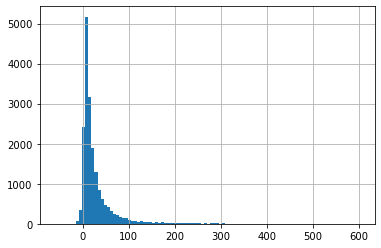

In [38]:
ab_sch['delay_mins'].hist(range = (-60,600),bins=100)

In [39]:
#filter out flights that departed more than 15 minutes early as this is highly unlikely
ab_sch = ab_sch[ab_sch['delay_mins']>-15]

In [40]:
mg1 = pd.merge(fs, ab_sch[['Marketing Airline ICAO Code','flight_number','Non-PA Airport Code','Concourse Desc','Gate Desc','Call Sign','sch_dt','dep_dt','delay_hours','delay_mins']], 
how='outer',left_on = ['DT_sched','airline_icao','Flight No','iata_code'], right_on = ['sch_dt','Marketing Airline ICAO Code','flight_number','Non-PA Airport Code'], indicator=True)

#### Checking the merge

In [41]:
# the majority of flights merged, but there are some that didn't match up. 
# What could explain mismatches? Maybe scheduled flights were canceled/rescheduled?
mg1._merge.value_counts()

both          18660
right_only     1440
left_only      1189
Name: _merge, dtype: int64

In [42]:
# create a new column that has the scheduled departure from whichever column isn't NA
mg1['mg_sch_dt'] = mg1['DT_sched']
mg1.loc[mg1._merge == 'right_only','mg_sch_dt'] = mg1.loc[mg1._merge == 'right_only','sch_dt']
mg1 = mg1.sort_values('mg_sch_dt').dropna(subset = 'mg_sch_dt') #sort values and drop the very few flights without block schedule value

In [43]:
# can we see a relationship between the flights in the FS vs AB that aren't matching up? Nothing jumps out
mismatches = mg1.loc[(mg1._merge == 'right_only') | (mg1._merge == 'left_only'), ['_merge','mg_sch_dt','delay_mins','DT_sched','sch_dt','dep_dt','Flight No','flight_number','iata_code','Non-PA Airport Code','Operating Airline Name','airline_icao','Marketing Airline ICAO Code']]
mismatches

,_merge,mg_sch_dt,delay_mins,DT_sched,sch_dt,dep_dt,Flight No,flight_number,iata_code,Non-PA Airport Code,Operating Airline Name,airline_icao,Marketing Airline ICAO Code
19849,right_only,2021-01-01 11:00:00,54.866667,NaT,2021-01-01 11:00:00,2021-01-01 11:54:52,NaN,9580.0,NaN,LIS,NaN,NaN,TAP
37,left_only,2021-01-01 19:30:00,NaN,2021-01-01 19:30:00,NaT,NaT,101.0,NaN,ORY,NaN,La Compagnie,DJT,NaN
44,left_only,2021-01-01 21:50:00,NaN,2021-01-01 21:50:00,NaT,NaT,103.0,NaN,ORY,NaN,La Compagnie,DJT,NaN
45,left_only,2021-01-01 23:55:00,NaN,2021-01-01 23:55:00,NaT,NaT,721.0,NaN,ORY,NaN,French Bee,FBU,NaN
94,left_only,2021-01-02 19:30:00,NaN,2021-01-02 19:30:00,NaT,NaT,101.0,NaN,ORY,NaN,La Compagnie,DJT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19843,left_only,2021-12-31 21:30:00,NaN,2021-12-31 21:30:00,NaT,NaT,1035.0,NaN,SJU,NaN,Spirit Airlines,NKS,NaN
19845,left_only,2021-12-31 23:10:00,NaN,2021-12-31 23:10:00,NaT,NaT,1293.0,NaN,STI,NaN,JetBlue Airways,JBU,NaN
19846,left_only,2021-12-31 23:25:00,NaN,2021-12-31 23:25:00,NaT,NaT,721.0,NaN,ORY,NaN,French Bee,FBU,NaN
19847,left_only,2021-12-31 23:55:00,NaN,2021-12-31 23:55:00,NaT,NaT,210.0,NaN,ATH,NaN,Emirates,UAE,NaN


In [44]:
mismatches['date'] = mismatches['mg_sch_dt'].dt.date

In [45]:
mismatches.head()

,_merge,mg_sch_dt,delay_mins,DT_sched,sch_dt,dep_dt,Flight No,flight_number,iata_code,Non-PA Airport Code,Operating Airline Name,airline_icao,Marketing Airline ICAO Code,date
19849,right_only,2021-01-01 11:00:00,54.866667,NaT,2021-01-01 11:00:00,2021-01-01 11:54:52,NaN,9580.0,NaN,LIS,NaN,NaN,TAP,2021-01-01
37,left_only,2021-01-01 19:30:00,NaN,2021-01-01 19:30:00,NaT,NaT,101.0,NaN,ORY,NaN,La Compagnie,DJT,NaN,2021-01-01
44,left_only,2021-01-01 21:50:00,NaN,2021-01-01 21:50:00,NaT,NaT,103.0,NaN,ORY,NaN,La Compagnie,DJT,NaN,2021-01-01
45,left_only,2021-01-01 23:55:00,NaN,2021-01-01 23:55:00,NaT,NaT,721.0,NaN,ORY,NaN,French Bee,FBU,NaN,2021-01-01
94,left_only,2021-01-02 19:30:00,NaN,2021-01-02 19:30:00,NaT,NaT,101.0,NaN,ORY,NaN,La Compagnie,DJT,NaN,2021-01-02


<AxesSubplot:xlabel='date'>

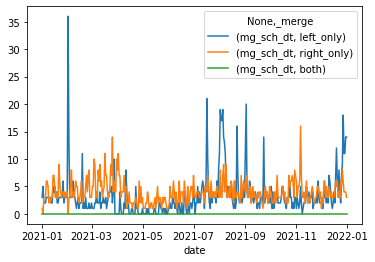

In [46]:
mismatches[['date','_merge','mg_sch_dt']].pivot_table(index='date', columns = '_merge', aggfunc='count').plot()

### Merge in weather data

In [47]:
# request_string = f'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/07114/2021-01-01/2021-12-31?unitGroup=us&elements=datetime%2Ctemp%2Cprecip%2Cprecipprob%2Cprecipcover%2Cpreciptype%2Csnow%2Csnowdepth%2Cwindgust%2Cwindspeed%2Cvisibility%2Csevererisk%2Cconditions%2Cdescription&include=hours&key=A32Z3KQNFYC38FNX7SM8M7G9P&contentType=csv'
weather = pd.read_csv(r'C:\Users\Gabriel\OneDrive\CUSP\Spring 2022 Classes\Capstone\Data\2022 Data\weather_detailed2021.csv')
weather.head()

,datetime,temp,precip,preciptype,snow,snowdepth,windgust,windspeed,visibility,conditions
0,2021-01-01T00:00:00,33.2,0.0,NaN,0.0,0.0,NaN,6.9,9.9,Partially cloudy
1,2021-01-01T01:00:00,29.1,0.0,NaN,0.0,0.0,NaN,6.9,9.9,Partially cloudy
2,2021-01-01T02:00:00,32.0,0.0,NaN,0.0,0.0,NaN,4.7,9.9,Partially cloudy
3,2021-01-01T03:00:00,31.9,0.0,NaN,0.0,0.0,NaN,4.7,9.9,Partially cloudy
4,2021-01-01T04:00:00,29.9,0.0,NaN,0.0,0.0,NaN,4.7,9.9,Partially cloudy


In [48]:
weather['datetime'] = pd.to_datetime(weather['datetime'])

In [49]:
weather['preciptype'] = weather['preciptype'].fillna('None')
weather['windgust'] = weather['windgust'].fillna(0)

In [50]:
mg1 = pd.merge(mg1,weather, how='left',left_on='hr_sched',right_on='datetime')

In [51]:
mg1.head(3)

,Unnamed: 0,DT_sched,Flight No,iata_code,International Domestic,Flight Distance,Flight Duration,Operating Airline Name,airline_icao,airline_type,Departure Concourse,date,Time,year,DOW_l,holiday,total_doses,BTS Aircraft Type Desc_1,ICAO Aircraft Code,IATA Aircraft Code,Seats,LF_adj,PAX_adj,PAX_bus,PAX_lei,airline_type_dum,region,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Hour_0,Hour_1,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,hr_sched,t30_sched,fcount_rolling,Marketing Airline ICAO Code,flight_number,Non-PA Airport Code,Concourse Desc,Gate Desc,Call Sign,sch_dt,dep_dt,delay_hours,delay_mins,_merge,mg_sch_dt,datetime,temp,precip,preciptype,snow,snowdepth,windgust,windspeed,visibility,conditions
0,56.0,2021-01-01 00:59:00,1035.0,SJU,Domestic,1608.0,256.0,Spirit Airlines,NKS,LC,B3,2021-01-01,00:59,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A321,A321,32B,228.0,1.172795,213.448633,32.610208,180.838425,1.0,Latin America & Caribbean,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 00:00:00,2021-01-01 00:30:00,1.0,NKS,1035.0,SJU,Concourse B-3,B61,NKS1035,2021-01-01 00:59:00,2021-01-01 01:05:58,0.116111,6.966667,both,2021-01-01 00:59:00,2021-01-01 00:00:00,33.2,0.0,None,0.0,0.0,0.0,6.9,9.9,Partially cloudy
1,89.0,2021-01-01 06:00:00,521.0,FLL,Domestic,1065.0,188.0,Spirit Airlines,NKS,LC,B1,2021-01-01,06:00,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A321,A321,32B,228.0,0.818869,149.302328,22.810078,126.492250,1.0,USA-Southeast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 06:00:00,2021-01-01 06:00:00,4.0,NKS,521.0,FLL,Concourse B-1,B41B,NKS521,2021-01-01 06:00:00,2021-01-01 06:24:24,0.406667,24.400000,both,2021-01-01 06:00:00,2021-01-01 06:00:00,29.9,0.0,None,0.0,0.0,0.0,3.3,9.9,Partially cloudy
2,23.0,2021-01-01 06:00:00,1646.0,DTW,Domestic,488.0,117.0,Delta Air Lines,DAL,TR,B1,2021-01-01,06:00,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A220-100,BCS1,221,109.0,0.764830,57.806095,8.831487,48.974608,0.0,USA-Midwest,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 06:00:00,2021-01-01 06:00:00,4.0,DAL,1646.0,DTW,Concourse B-1,B45,DAL1646,2021-01-01 06:00:00,2021-01-01 06:35:16,0.587778,35.266667,both,2021-01-01 06:00:00,2021-01-01 06:00:00

In [52]:
df = mg1.loc[mg1._merge == 'both']

In [53]:
target = df['delay_mins']

In [54]:
preds = pd.concat([df.loc[:,['Flight Distance','holiday','Seats','airline_type_dum','fcount_rolling','temp','precip','snow','snowdepth','windgust','windspeed','visibility']],df.loc[:,'Region_Africa':'airline_iata_TP']],axis=1)
preds

,Flight Distance,holiday,Seats,airline_type_dum,fcount_rolling,temp,precip,snow,snowdepth,windgust,windspeed,visibility,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP
0,1608.0,1.0,228.0,1.0,1.0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1065.0,1.0,228.0,1.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,488.0,1.0,109.0,0.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,746.0,1.0,160.0,0.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,746.0,1.0,160.0,0.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21279,1504.0,1.0,182.0,1.0,4.0,51.2,0.0,0.0,0.0,0.0,3.4,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21280,4052.0,1.0,293.0,0.0,4.0,51.2,0.0,0.0,0.0,0.0,3.4,6.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21281,4052.0,1.0,293.0,0.0,4.0,51.2,0.0,0.0,0.0,0.0,3.4,6.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21282,5181.0,1.0,270.0,0.0,5.0,49.9,0.0,0.0,0.0,0.0,0.0,6.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
lr = LinearRegression()
lr.fit(preds, target)

LinearRegression()

In [56]:
lr.score(preds, target)

0.06739436536403332

In [57]:
df['delay_mins_pred'] = lr.predict(preds)

In [58]:
df['no_delay'] = 0

In [59]:
from sklearn.metrics import r2_score


r2_score(df['delay_mins_pred'],df['no_delay'])

-4.501986099250561

<AxesSubplot:>

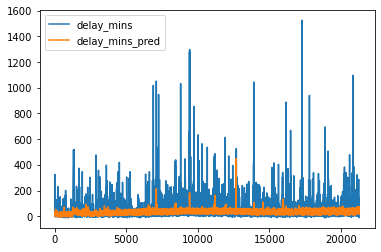

In [60]:
df[['delay_mins','delay_mins_pred']].plot()

In [61]:
df.head()

,Unnamed: 0,DT_sched,Flight No,iata_code,International Domestic,Flight Distance,Flight Duration,Operating Airline Name,airline_icao,airline_type,Departure Concourse,date,Time,year,DOW_l,holiday,total_doses,BTS Aircraft Type Desc_1,ICAO Aircraft Code,IATA Aircraft Code,Seats,LF_adj,PAX_adj,PAX_bus,PAX_lei,airline_type_dum,region,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Hour_0,Hour_1,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,hr_sched,t30_sched,fcount_rolling,Marketing Airline ICAO Code,flight_number,Non-PA Airport Code,Concourse Desc,Gate Desc,Call Sign,sch_dt,dep_dt,delay_hours,delay_mins,_merge,mg_sch_dt,datetime,temp,precip,preciptype,snow,snowdepth,windgust,windspeed,visibility,conditions,delay_mins_pred,no_delay
0,56.0,2021-01-01 00:59:00,1035.0,SJU,Domestic,1608.0,256.0,Spirit Airlines,NKS,LC,B3,2021-01-01,00:59,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A321,A321,32B,228.0,1.172795,213.448633,32.610208,180.838425,1.0,Latin America & Caribbean,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 00:00:00,2021-01-01 00:30:00,1.0,NKS,1035.0,SJU,Concourse B-3,B61,NKS1035,2021-01-01 00:59:00,2021-01-01 01:05:58,0.116111,6.966667,both,2021-01-01 00:59:00,2021-01-01 00:00:00,33.2,0.0,None,0.0,0.0,0.0,6.9,9.9,Partially cloudy,17.805399,0
1,89.0,2021-01-01 06:00:00,521.0,FLL,Domestic,1065.0,188.0,Spirit Airlines,NKS,LC,B1,2021-01-01,06:00,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A321,A321,32B,228.0,0.818869,149.302328,22.810078,126.492250,1.0,USA-Southeast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 06:00:00,2021-01-01 06:00:00,4.0,NKS,521.0,FLL,Concourse B-1,B41B,NKS521,2021-01-01 06:00:00,2021-01-01 06:24:24,0.406667,24.400000,both,2021-01-01 06:00:00,2021-01-01 06:00:00,29.9,0.0,None,0.0,0.0,0.0,3.3,9.9,Partially cloudy,8.349101,0
2,23.0,2021-01-01 06:00:00,1646.0,DTW,Domestic,488.0,117.0,Delta Air Lines,DAL,TR,B1,2021-01-01,06:00,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A220-100,BCS1,221,109.0,0.764830,57.806095,8.831487,48.974608,0.0,USA-Midwest,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 06:00:00,2021-01-01 06:00:00,4.0,DAL,1646.0,DTW,Concourse B-1,B45,DAL1646,2021-01-01 06:00:00,2021-01-01 06:35:16,0.587778,35.266

In [62]:
df_act_pax = df[['PAX_adj','dep_dt']].groupby(
    pd.Grouper(key='dep_dt', freq='1H')).sum().reset_index()
df_act_pax

,dep_dt,PAX_adj
0,2021-01-01 01:00:00,213.448633
1,2021-01-01 02:00:00,0.000000
2,2021-01-01 03:00:00,0.000000
3,2021-01-01 04:00:00,0.000000
4,2021-01-01 05:00:00,0.000000
...,...,...
8753,2021-12-31 18:00:00,506.482391
8754,2021-12-31 19:00:00,467.667293
8755,2021-12-31 20:00:00,425.082388
8756,2021-12-31 21:00:00,299.069233


In [63]:
df['dep_pred'] = df['DT_sched'] + pd.to_timedelta(df['delay_mins_pred'],unit='minutes')

In [64]:
df_pred_pax = df[['PAX_adj','dep_pred']].groupby(
    pd.Grouper(key='dep_pred', freq='10t')).sum().reset_index()
df_pred_pax

,dep_pred,PAX_adj
0,2021-01-01 01:10:00,213.448633
1,2021-01-01 01:20:00,0.000000
2,2021-01-01 01:30:00,0.000000
3,2021-01-01 01:40:00,0.000000
4,2021-01-01 01:50:00,0.000000
...,...,...
52543,2021-12-31 22:20:00,0.000000
52544,2021-12-31 22:30:00,0.000000
52545,2021-12-31 22:40:00,0.000000
52546,2021-12-31 22:50:00,0.000000


In [65]:
ts = pd.DataFrame(data = pd.date_range(start='1/1/2021',end='2021-12-31 23:50:00',freq='1H'),columns = ['dt'])

In [66]:
ts

,dt
0,2021-01-01 00:00:00
1,2021-01-01 01:00:00
2,2021-01-01 02:00:00
3,2021-01-01 03:00:00
4,2021-01-01 04:00:00
...,...
8755,2021-12-31 19:00:00
8756,2021-12-31 20:00:00
8757,2021-12-31 21:00:00
8758,2021-12-31 22:00:00


In [67]:
ts = pd.merge(ts,df_act_pax,how='left',left_on='dt',right_on = 'dep_dt')

In [68]:
ts = pd.merge(ts,df_pred_pax,how='left',left_on='dt',right_on = 'dep_pred')

In [69]:
ts.fillna(0,inplace=True)

In [70]:
r2_score(ts['PAX_adj_y'],ts['PAX_adj_x'])

-13.898752632033217

In [71]:
preds.head()

,Flight Distance,holiday,Seats,airline_type_dum,fcount_rolling,temp,precip,snow,snowdepth,windgust,windspeed,visibility,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP
0,1608.0,1.0,228.0,1.0,1.0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1065.0,1.0,228.0,1.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,488.0,1.0,109.0,0.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,746.0,1.0,160.0,0.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,746.0,1.0,160.0,0.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
#split data by month instead of random train-test split
X_test = preds[preds['Month'] == 12]
y_test = target[preds['Month'] == 12]
X_train = preds[preds['Month'] != 12]
y_train = target[preds['Month'] != 12]

In [73]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16281, 64) (2379, 64) (16281,) (2379,)


In [74]:
from sklearn.preprocessing import StandardScaler


ss_x = StandardScaler()
ss_x.fit(X_train[['Flight Distance', 'Seats',
       'fcount_rolling', 'temp', 'precip', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'visibility','Month']])
X_train[['Flight Distance', 'Seats',
       'fcount_rolling', 'temp', 'precip', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'visibility','Month']] = ss_x.transform(X_train[['Flight Distance', 'Seats',
       'fcount_rolling', 'temp', 'precip', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'visibility','Month']]
       )
X_test[['Flight Distance', 'Seats',
       'fcount_rolling', 'temp', 'precip', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'visibility','Month']] = ss_x.transform(X_test[['Flight Distance', 'Seats',
       'fcount_rolling', 'temp', 'precip', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'visibility','Month']]
       )


In [75]:
#This is a time-series splitter for cross-validating, instead of using gridsearchcv's default kfolds.
tscv = TimeSeriesSplit(n_splits = 5)

### OLS

In [76]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [77]:
print(r2_score(y_train, lr.predict(X_train)))
print(r2_score(y_test, lr.predict(X_test)))

0.07166360004794325
-0.030224141921873837


{'alpha': 7543.120063354608}
-0.02262682662272315


<AxesSubplot:>

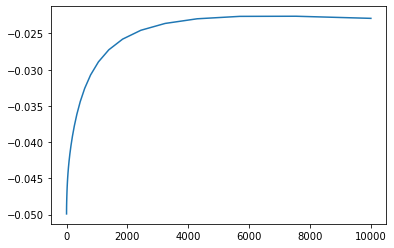

In [78]:
alpha = np.logspace(-2,4,50)
param_grid = {'alpha': alpha}
rr = Ridge()
clf_rr = GridSearchCV(rr, param_grid=param_grid, cv=tscv)
clf_rr.fit(X_train, y_train)
print(clf_rr.best_params_)
print(clf_rr.best_score_)
pd.Series(clf_rr.cv_results_['mean_test_score'],index=alpha).plot()

In [79]:
r2_score(y_test,clf_rr.predict(X_test))

-0.004217926391133497

{'alpha': 7.847599703514606}
-0.0330610566766288


<AxesSubplot:>

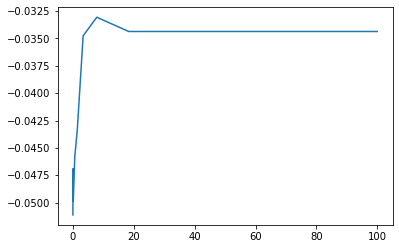

In [80]:
alpha = np.logspace(-5,2,20)
param_grid = {'alpha': alpha}
lar = Lasso()
clf_lar = GridSearchCV(lar, param_grid=param_grid, cv=tscv)
clf_lar.fit(X_train, y_train)
print(clf_lar.best_params_)
print(clf_lar.best_score_)
pd.Series(clf_lar.cv_results_['mean_test_score'],index=alpha).plot()

In [81]:
r2_score(y_test,clf_lar.predict(X_test))

-0.020470254491210094

{'max_depth': 4}
-0.025027889457731534


<AxesSubplot:>

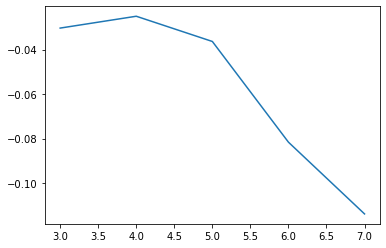

In [82]:
md = range(3,8,1)
param_grid = {'max_depth': md}
rf = RandomForestRegressor(n_estimators=100)
clf_rf = GridSearchCV(rf, param_grid=param_grid, cv=tscv)
clf_rf = clf_rf.fit(X_train, y_train)
print(clf_rf.best_params_)
print(clf_rf.best_score_)
pd.Series(clf_rf.cv_results_['mean_test_score'],index=md).plot()

In [83]:
r2_score(y_test,clf_rf.predict(X_test))

-0.027222431129188207

In [84]:
gbr = GradientBoostingRegressor()

param_grid = {
                'max_depth':[2,3,4],
                'n_estimators':[50,100,200],
                'learning_rate':[.1,.01,.001]
                }

clf_gbr = GridSearchCV(gbr, param_grid=param_grid,verbose=3,n_jobs=-1, cv=tscv,)
clf_gbr.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [50, 100, 200]},
             verbose=3)

In [85]:
print(clf_gbr.best_params_)
print(clf_gbr.best_score_)

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
-0.010184218342843398


In [86]:
r2_score(y_test,clf_gbr.predict(X_test))

-0.023412572427627287

Fitting 5 folds for each of 8 candidates, totalling 40 fits
{'n_neighbors': 24}
-0.04237921184201734


<AxesSubplot:>

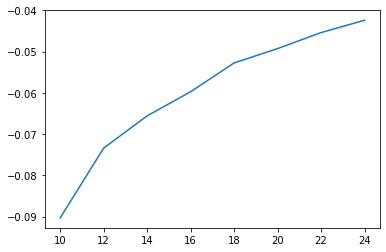

In [87]:
knr = KNeighborsRegressor(weights='distance',n_jobs=-1)

nn = [n for n in range(10,25,2)]

param_grid = {
                'n_neighbors':nn,

                }

clf_knr = GridSearchCV(knr, param_grid=param_grid,verbose=3,n_jobs=-1, cv=tscv,)
clf_knr.fit(X_train,y_train)


print(clf_knr.best_params_)

print(clf_knr.best_score_)

pd.Series(clf_knr.cv_results_['mean_test_score'],index=nn).plot()

## Try as a time series problem

In [88]:
df.head()

,Unnamed: 0,DT_sched,Flight No,iata_code,International Domestic,Flight Distance,Flight Duration,Operating Airline Name,airline_icao,airline_type,Departure Concourse,date,Time,year,DOW_l,holiday,total_doses,BTS Aircraft Type Desc_1,ICAO Aircraft Code,IATA Aircraft Code,Seats,LF_adj,PAX_adj,PAX_bus,PAX_lei,airline_type_dum,region,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Hour_0,Hour_1,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,hr_sched,t30_sched,fcount_rolling,Marketing Airline ICAO Code,flight_number,Non-PA Airport Code,Concourse Desc,Gate Desc,Call Sign,sch_dt,dep_dt,delay_hours,delay_mins,_merge,mg_sch_dt,datetime,temp,precip,preciptype,snow,snowdepth,windgust,windspeed,visibility,conditions,delay_mins_pred,no_delay,dep_pred
0,56.0,2021-01-01 00:59:00,1035.0,SJU,Domestic,1608.0,256.0,Spirit Airlines,NKS,LC,B3,2021-01-01,00:59,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A321,A321,32B,228.0,1.172795,213.448633,32.610208,180.838425,1.0,Latin America & Caribbean,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 00:00:00,2021-01-01 00:30:00,1.0,NKS,1035.0,SJU,Concourse B-3,B61,NKS1035,2021-01-01 00:59:00,2021-01-01 01:05:58,0.116111,6.966667,both,2021-01-01 00:59:00,2021-01-01 00:00:00,33.2,0.0,None,0.0,0.0,0.0,6.9,9.9,Partially cloudy,17.805399,0,2021-01-01 01:16:48.323941140
1,89.0,2021-01-01 06:00:00,521.0,FLL,Domestic,1065.0,188.0,Spirit Airlines,NKS,LC,B1,2021-01-01,06:00,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A321,A321,32B,228.0,0.818869,149.302328,22.810078,126.492250,1.0,USA-Southeast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 06:00:00,2021-01-01 06:00:00,4.0,NKS,521.0,FLL,Concourse B-1,B41B,NKS521,2021-01-01 06:00:00,2021-01-01 06:24:24,0.406667,24.400000,both,2021-01-01 06:00:00,2021-01-01 06:00:00,29.9,0.0,None,0.0,0.0,0.0,3.3,9.9,Partially cloudy,8.349101,0,2021-01-01 06:08:20.946086820
2,23.0,2021-01-01 06:00:00,1646.0,DTW,Domestic,488.0,117.0,Delta Air Lines,DAL,TR,B1,2021-01-01,06:00,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A220-100,BCS1,221,109.0,0.764830,57.806095,8.831487,48.974608,0.0,USA-Midwest,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 06:00:00,2021-01-01 06:00:00,4.0,DAL,1646.0,DTW,Concourse B-

In [89]:
preds.head()

,Flight Distance,holiday,Seats,airline_type_dum,fcount_rolling,temp,precip,snow,snowdepth,windgust,windspeed,visibility,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP
0,1608.0,1.0,228.0,1.0,1.0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1065.0,1.0,228.0,1.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,488.0,1.0,109.0,0.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,746.0,1.0,160.0,0.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,746.0,1.0,160.0,0.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# number pax scheduled to depart, number flights scheduled to depart, holiday, weather, 

In [91]:
df.head()

,Unnamed: 0,DT_sched,Flight No,iata_code,International Domestic,Flight Distance,Flight Duration,Operating Airline Name,airline_icao,airline_type,Departure Concourse,date,Time,year,DOW_l,holiday,total_doses,BTS Aircraft Type Desc_1,ICAO Aircraft Code,IATA Aircraft Code,Seats,LF_adj,PAX_adj,PAX_bus,PAX_lei,airline_type_dum,region,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,Hour_0,Hour_1,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,hr_sched,t30_sched,fcount_rolling,Marketing Airline ICAO Code,flight_number,Non-PA Airport Code,Concourse Desc,Gate Desc,Call Sign,sch_dt,dep_dt,delay_hours,delay_mins,_merge,mg_sch_dt,datetime,temp,precip,preciptype,snow,snowdepth,windgust,windspeed,visibility,conditions,delay_mins_pred,no_delay,dep_pred
0,56.0,2021-01-01 00:59:00,1035.0,SJU,Domestic,1608.0,256.0,Spirit Airlines,NKS,LC,B3,2021-01-01,00:59,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A321,A321,32B,228.0,1.172795,213.448633,32.610208,180.838425,1.0,Latin America & Caribbean,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 00:00:00,2021-01-01 00:30:00,1.0,NKS,1035.0,SJU,Concourse B-3,B61,NKS1035,2021-01-01 00:59:00,2021-01-01 01:05:58,0.116111,6.966667,both,2021-01-01 00:59:00,2021-01-01 00:00:00,33.2,0.0,None,0.0,0.0,0.0,6.9,9.9,Partially cloudy,17.805399,0,2021-01-01 01:16:48.323941140
1,89.0,2021-01-01 06:00:00,521.0,FLL,Domestic,1065.0,188.0,Spirit Airlines,NKS,LC,B1,2021-01-01,06:00,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A321,A321,32B,228.0,0.818869,149.302328,22.810078,126.492250,1.0,USA-Southeast,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 06:00:00,2021-01-01 06:00:00,4.0,NKS,521.0,FLL,Concourse B-1,B41B,NKS521,2021-01-01 06:00:00,2021-01-01 06:24:24,0.406667,24.400000,both,2021-01-01 06:00:00,2021-01-01 06:00:00,29.9,0.0,None,0.0,0.0,0.0,3.3,9.9,Partially cloudy,8.349101,0,2021-01-01 06:08:20.946086820
2,23.0,2021-01-01 06:00:00,1646.0,DTW,Domestic,488.0,117.0,Delta Air Lines,DAL,TR,B1,2021-01-01,06:00,2021.0,Friday,1.0,4438527.0,AIRBUS INDUSTRIE A220-100,BCS1,221,109.0,0.764830,57.806095,8.831487,48.974608,0.0,USA-Midwest,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-01 06:00:00,2021-01-01 06:00:00,4.0,DAL,1646.0,DTW,Concourse B-

In [92]:
preds_ts = pd.concat([df.loc[:,['sch_dt','PAX_adj','holiday','Seats','fcount_rolling','temp','precip','snow','snowdepth','windgust','windspeed','visibility','airline_type_dum']],df.loc[:,'Region_Africa':'airline_iata_TP']],axis=1)

In [93]:
preds_ts.head()

,sch_dt,PAX_adj,holiday,Seats,fcount_rolling,temp,precip,snow,snowdepth,windgust,windspeed,visibility,airline_type_dum,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP
0,2021-01-01 00:59:00,213.448633,1.0,228.0,1.0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-01 06:00:00,149.302328,1.0,228.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2021-01-01 06:00:00,57.806095,1.0,109.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-01 06:15:00,101.766704,1.0,160.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-01-01 06:15:00,101.766704,1.0,160.0,4.0,29.9,0.0,0.0,0.0,0.0,3.3,9.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
preds_ts.loc[:,'airline_type_dum':] = preds_ts.loc[:,'airline_type_dum':].multiply(preds_ts['PAX_adj'], axis='index')

In [95]:
sch_ts = preds_ts[['sch_dt','PAX_adj']].groupby(by = pd.Grouper(key='sch_dt',freq='10t')).sum()
sch_ts.head()

,PAX_adj
sch_dt,
2021-01-01 00:50:00,213.448633
2021-01-01 01:00:00,0.000000
2021-01-01 01:10:00,0.000000
2021-01-01 01:20:00,0.000000
2021-01-01 01:30:00,0.000000


In [96]:
preds_ts.columns

Index(['sch_dt', 'PAX_adj', 'holiday', 'Seats', 'fcount_rolling', 'temp',
       'precip', 'snow', 'snowdepth', 'windgust', 'windspeed', 'visibility',
       'airline_type_dum', 'Region_Africa', 'Region_Asia', 'Region_Canada',
       'Region_Europe', 'Region_Latin America & Caribbean',
       'Region_USA-Midwest', 'Region_USA-Northeast', 'Region_USA-Pacific West',
       'Region_USA-Plains', 'Region_USA-Southeast', 'domintl_dum_0',
       'domintl_dum_1', 'Time Category_Afternoon', 'Time Category_Evening',
       'Time Category_Morning', 'Time Category_Overnight', 'DOW_0', 'DOW_1',
       'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5', 'DOW_6', 'ADG_II', 'ADG_III',
       'ADG_IV', 'ADG_V', 'ADG_VI', 'Month', 'airline_iata_AI',
       'airline_iata_AV', 'airline_iata_B0', 'airline_iata_B6',
       'airline_iata_BA', 'airline_iata_BF', 'airline_iata_DL',
       'airline_iata_EI', 'airline_iata_EK', 'airline_iata_ET',
       'airline_iata_F9', 'airline_iata_FI', 'airline_iata_G4',
       'airline_ia

In [97]:
preds_ts = preds_ts.groupby(by = pd.Grouper(key='sch_dt',freq='10t')).agg({'holiday':'mean', 'Seats':'sum', 'fcount_rolling':'count', 'temp':'mean',
       'precip':'mean', 'snow':'mean', 'snowdepth':'mean', 'windgust':'mean', 'windspeed':'mean', 'visibility':'mean',
       'airline_type_dum':'sum', 'Region_Africa':'sum', 'Region_Asia':'sum', 'Region_Canada':'sum',
       'Region_Europe':'sum', 'Region_Latin America & Caribbean':'sum',
       'Region_USA-Midwest':'sum', 'Region_USA-Northeast':'sum', 'Region_USA-Pacific West':'sum',
       'Region_USA-Plains':'sum', 'Region_USA-Southeast':'sum', 'domintl_dum_0':'sum',
       'domintl_dum_1':'sum', 'Time Category_Afternoon':'sum', 'Time Category_Evening':'sum',
       'Time Category_Morning':'sum', 'Time Category_Overnight':'sum', 'DOW_0':'sum', 'DOW_1':'sum',
       'DOW_2':'sum', 'DOW_3':'sum', 'DOW_4':'sum', 'DOW_5':'sum', 'DOW_6':'sum', 'ADG_II':'sum', 'ADG_III':'sum',
       'ADG_IV':'sum', 'ADG_V':'sum', 'ADG_VI':'sum', 'Month':'sum', 'airline_iata_AI':'sum',
       'airline_iata_AV':'sum', 'airline_iata_B0':'sum', 'airline_iata_B6':'sum',
       'airline_iata_BA':'sum', 'airline_iata_BF':'sum', 'airline_iata_DL':'sum',
       'airline_iata_EI':'sum', 'airline_iata_EK':'sum', 'airline_iata_ET':'sum',
       'airline_iata_F9':'sum', 'airline_iata_FI':'sum', 'airline_iata_G4':'sum',
       'airline_iata_LH':'sum', 'airline_iata_LO':'sum', 'airline_iata_LX':'sum',
       'airline_iata_LY':'sum', 'airline_iata_NK':'sum', 'airline_iata_OS':'sum',
       'airline_iata_PD':'sum', 'airline_iata_SK':'sum', 'airline_iata_SY':'sum',
       'airline_iata_TP':'sum'})
preds_ts.head()

,holiday,Seats,fcount_rolling,temp,precip,snow,snowdepth,windgust,windspeed,visibility,airline_type_dum,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP
sch_dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:50:00,1.0,228.0,1,33.2,0.0,0.0,0.0,0.0,6.9,9.9,213.448633,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:00:00,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:10:00,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:20:00,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:30:00,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [98]:
preds_ts = preds_ts.fillna(method='ffill')
preds_ts.head()

,holiday,Seats,fcount_rolling,temp,precip,snow,snowdepth,windgust,windspeed,visibility,airline_type_dum,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP
sch_dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:50:00,1.0,228.0,1,33.2,0.0,0.0,0.0,0.0,6.9,9.9,213.448633,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:00:00,1.0,0.0,0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:10:00,1.0,0.0,0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:20:00,1.0,0.0,0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2021-01-01 01:30:00,1.0,0.0,0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [99]:
df_act_pax.head()

,dep_dt,PAX_adj
0,2021-01-01 01:00:00,213.448633
1,2021-01-01 02:00:00,0.000000
2,2021-01-01 03:00:00,0.000000
3,2021-01-01 04:00:00,0.000000
4,2021-01-01 05:00:00,0.000000


In [100]:
preds_ts.shape

(52543, 63)

In [101]:
tsts = pd.merge(preds_ts.reset_index(),df_act_pax,how='outer',left_on='sch_dt', right_on='dep_dt')
tsts.head()

,sch_dt,holiday,Seats,fcount_rolling,temp,precip,snow,snowdepth,windgust,windspeed,visibility,airline_type_dum,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP,dep_dt,PAX_adj
0,2021-01-01 00:50:00,1.0,228.0,1.0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,213.448633,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,213.448633,0.0,0.0,0.0,0.0,0.0,NaT,NaN
1,2021-01-01 01:00:00,1.0,0.0,0.0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2021-01-01 01:00:00,213.448633
2,2021-01-01 01:10:00,1.0,0.0,0.0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,NaT,NaN
3,2021-01-01 01:20:00,1.0,0.0,0.0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,NaT,NaN
4,2021-01-01 01:30:00,1.0,0.0,0.0,33.2,0.0,0.0,0.0,0.0,6.9,9.9,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,NaT,NaN


In [102]:
tsts = tsts.drop('dep_dt',axis=1)

In [103]:
tsts = tsts.fillna(0)

In [104]:
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (

    RNNModel,
    AutoARIMA,
    VARIMA,
    ExponentialSmoothing,
    RegressionModel,
    LinearRegressionModel,
    RandomForest
)
from darts.metrics import mape, smape, rmse
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

2022-08-21 22:55:37 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.


In [105]:
from sklearn.linear_model import PoissonRegressor

In [106]:
tsts = tsts.iloc[:-1,:]
tsts.tail()

,sch_dt,holiday,Seats,fcount_rolling,temp,precip,snow,snowdepth,windgust,windspeed,visibility,airline_type_dum,Region_Africa,Region_Asia,Region_Canada,Region_Europe,Region_Latin America & Caribbean,Region_USA-Midwest,Region_USA-Northeast,Region_USA-Pacific West,Region_USA-Plains,Region_USA-Southeast,domintl_dum_0,domintl_dum_1,Time Category_Afternoon,Time Category_Evening,Time Category_Morning,Time Category_Overnight,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6,ADG_II,ADG_III,ADG_IV,ADG_V,ADG_VI,Month,airline_iata_AI,airline_iata_AV,airline_iata_B0,airline_iata_B6,airline_iata_BA,airline_iata_BF,airline_iata_DL,airline_iata_EI,airline_iata_EK,airline_iata_ET,airline_iata_F9,airline_iata_FI,airline_iata_G4,airline_iata_LH,airline_iata_LO,airline_iata_LX,airline_iata_LY,airline_iata_NK,airline_iata_OS,airline_iata_PD,airline_iata_SK,airline_iata_SY,airline_iata_TP,PAX_adj
52538,2021-12-31 21:10:00,1.0,270.0,1.0,49.9,0.0,0.0,0.0,0.0,0.0,6.2,0.0,104.845477,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.845477,0.0,104.845477,0.0,0.0,0.0,0.0,0.0,0.0,104.845477,0.0,0.0,0.0,0.0,0.0,104.845477,0.0,1258.145727,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,104.845477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52539,2021-12-31 21:20:00,1.0,0.0,0.0,49.9,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52540,2021-12-31 21:30:00,1.0,0.0,0.0,49.9,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52541,2021-12-31 21:40:00,1.0,0.0,0.0,49.9,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52542,2021-12-31 21:50:00,1.0,214.0,1.0,49.9,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.000000,0.0,0.0,127.748898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.748898,0.0,127.748898,0.0,0.0,0.0,0.0,0.0,0.0,127.748898,0.0,0.0,0.0,0.0,0.0,127.748898,0.0,1532.986773,0.0,0.0,0.0,0.0,127.748898,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
tsts['sch_dt'] = pd.to_datetime(tsts['sch_dt'])

In [108]:
tsts = tsts.set_index('sch_dt')

In [109]:
cov = TimeSeries.from_dataframe(tsts.loc[:,:'airline_iata_TP'])
tar = TimeSeries.from_series(tsts.loc[:,'PAX_adj'])

In [110]:
cov_train, cov_test = cov.split_before(pd.Timestamp(2021,12,1))
tar_train, tar_test = tar.split_before(pd.Timestamp(2021,12,1))

In [111]:
regr_model = RegressionModel(lags=None, lags_future_covariates=[i for i in range(-24,1)])

regr_model.fit(tar_train, future_covariates=cov)

In [112]:
pred = regr_model.predict(n=4445,future_covariates=cov)

In [113]:
r2_score(tar_test[:4445].pd_dataframe(),pred.pd_dataframe())

0.41671525122651865

In [114]:
df_pred_pax.set_index('dep_pred', inplace=True)
df_pred_pax

,PAX_adj
dep_pred,
2021-01-01 01:10:00,213.448633
2021-01-01 01:20:00,0.000000
2021-01-01 01:30:00,0.000000
2021-01-01 01:40:00,0.000000
2021-01-01 01:50:00,0.000000
...,...
2021-12-31 22:20:00,0.000000
2021-12-31 22:30:00,0.000000
2021-12-31 22:40:00,0.000000


In [115]:
def plot_agg_result(actual, pred,frequency,start_date,end_date):

    test_df = actual.pd_dataframe()
    test_df.columns = ['dep_act']
    test_df = pd.merge(test_df, pred.pd_dataframe(), how='right',left_index=True, right_index=True)
    test_df.rename({'PAX_adj':'dep_pred_ts'},axis=1,inplace=True)
    test_df = pd.merge(test_df, df_pred_pax, how='left',left_index=True, right_index=True)
    test_df.rename({'PAX_adj':'dep_pred_xflight'},axis=1,inplace=True)
    test_df = pd.merge(test_df, sch_ts, how='left',left_index=True,right_index=True) #add scheduled departing pax
    test_df.rename({'PAX_adj':'sch'},axis=1,inplace=True)
    
    
    test_df = test_df.reset_index()
    test_df = test_df.groupby(pd.Grouper(key="sch_dt", freq=frequency)).sum()

    #don't allow negative values
    test_df['dep_pred_ts'].clip(lower=0,inplace=True)

    s_date = pd.to_datetime(start_date)
    e_date = pd.to_datetime(end_date)

    print(f"Time series r2: {r2_score(test_df.loc[:,'dep_act'],test_df.loc[:,'dep_pred_ts'])}")
    print(f"Per flight r2: {r2_score(test_df.loc[:,'dep_act'],test_df.loc[:,'dep_pred_xflight'])}")
    print(f"Using the schedule only r2: {r2_score(test_df.loc[:,'dep_act'],test_df.loc[:,'sch'])}")

    # print(r2_score(test_df.loc[:,'dep_act'],test_df.loc[:,'sch']))
    test_df.loc[(test_df.index >= s_date) & (test_df.index <= e_date),:].plot()

    return test_df

Time series r2: 0.4967608675446703
Per flight r2: -0.26336084803883053
Using the schedule only r2: -0.22049098289618274


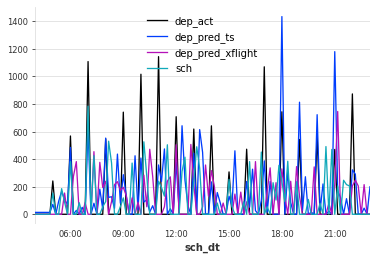

In [131]:
abcd = plot_agg_result(tar_test[:4445], pred,'10t','2021-12-23 04:00','2021-12-23 23:00')

In [117]:
abcd.reset_index().groupby(pd.Grouper(key="sch_dt", freq='1H')).sum()

,dep_act,dep_pred_ts,dep_pred_xflight,sch
sch_dt,,,,
2021-12-01 00:00:00,290.387758,312.711128,194.000691,0.000000
2021-12-01 01:00:00,0.000000,146.262896,0.000000,0.000000
2021-12-01 02:00:00,0.000000,107.985656,0.000000,0.000000
2021-12-01 03:00:00,0.000000,44.970539,0.000000,0.000000
2021-12-01 04:00:00,0.000000,74.275779,0.000000,0.000000
...,...,...,...,...
2021-12-31 16:00:00,573.250849,586.182885,464.227633,852.764390
2021-12-31 17:00:00,463.398690,399.738336,388.536757,581.344324
2021-12-31 18:00:00,506.482391,791.047549,704.434290,252.454779


## Queuing

In [118]:
import math

In [119]:
def queue(servers, lam, mu):
    p = lam / mu
    #probability of no passengers in the system
    pr=0
    if lam<=servers*mu:
        for n in range(servers):
            sss = p**n / math.factorial(n)
            pr += sss

        pr = (pr + p**servers/(math.factorial(servers) * (1-(p/servers))))**-1

    # utilization
    ut = np.min([1,p/servers])

    if ut<1:
        #average number in queue
        Lq = pr*p**(servers+1) / (servers * math.factorial(servers) * (1-p/servers)**2)
        #average number in system
        Ls = Lq + p
        # expected average system time
        try:
            Ws_10m = Ls / lam
        except:
            Ws_10m = 0
        # expected queue time
        Wq_10m = Ws_10m - 1/mu
        
        # convert wait time from 10-minute increments to 1-minute
        Ws = Ws_10m * 10
        Wq = Wq_10m * 10
    else:
        Lq = 999
        Ls = 999
        Ws = 999
        Wq = 999

    return ut, Ls, Ws




In [120]:
queue(4,499/6,125/6)

(0.9980000000000001, 500.77953106913026, 60.2139716716389)

In [121]:
conc_2 = ['B1',"B2"]
wt_c = [f'{c}_waittime' for c in conc_2]
wt_c

['B1_waittime', 'B2_waittime']

In [122]:
from numpy import result_type

abcd[['ut','len','wait']] = abcd['dep_act'].apply(lambda x: queue(5, x, 125/6)).to_list()
abcd.head()


,dep_act,dep_pred_ts,dep_pred_xflight,sch,ut,len,wait
sch_dt,,,,,,,
2021-12-01 00:00:00,290.387758,272.129378,0.000000,0.0,1.0,999.0,999.0
2021-12-01 00:10:00,0.000000,0.000000,194.000691,0.0,0.0,0.0,0.0
2021-12-01 00:20:00,0.000000,6.656244,0.000000,0.0,0.0,0.0,0.0
2021-12-01 00:30:00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2021-12-01 00:40:00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [123]:
lanes=2
l = 600
u = 125

p = l / u

In [124]:
#probability of no passengers in the system
pr=0
if l<=lanes*u:
    for n in range(lanes):
        sss = p**n / math.factorial(n)
        pr += sss

    pr = (pr + p**lanes/(math.factorial(lanes) * (1-(p/lanes))))**-1
print(pr)

0


In [125]:
# utilization
ut = np.min([1,p/lanes])
print(ut)

1.0


In [126]:

if ut<=1:
    #average number in queue
    Lq = pr*p**(lanes+1) / (lanes * math.factorial(lanes) * (1-p/lanes)**2)
    #average number in system
    Ls = Lq + p
    # expected average system time
    Ws = Ls / l
    # expected queue time
    Wq = Ws - 1/u
else:
    Lq = 9999
    Ls = 9999
    Ws = 9
    Wq = 9
print(Lq)
print(Ls)
print(Ws)
print(Wq)

0.0
4.8
0.008
0.0


In [127]:
from statsforecast.models import croston_classic